In [1]:
import sys
import astropy.units as u
import gammapy
import matplotlib.pylab as plt
import numpy as np
import pyximport
import yaml
from gammapy.datasets import FluxPointsDataset, Datasets
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from gammapy.modeling import Fit, Parameter, Parameters
from gammapy.modeling.models import Models, FoVBackgroundModel, Model
from matplotlib import rc
from scipy.interpolate import interp2d

# import random
sys.path.append("/home/katrin/Documents/nuisance_summary/")
sys.path.append("../../")
import Dataset_load  # noqa: E402
from Dataset_Creation import sys_dataset  # noqa: E402

print(f"loaded gammapy version: {gammapy.__version__} ")
print("Supposed to be 1.0 (21-12-2022)")
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)
pyximport.install()

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-12-2022)


(None, <pyximport.pyximport.PyxImporter at 0x7f88cc4ed070>)

## Read dataset

In [27]:
scaled_amplitude = Parameter("amplitude", value=1e-12)
lambda_ = Parameter("lambda_", value=1/60)

dataset_asimov = Dataset_load.create_asimov(
    model="ecpl", source="PKSflare", parameters=Parameters([scaled_amplitude, lambda_])
)

shift = 0.0
tilt = 0.0
bias = 0.1
resolution = 0.1

sys_ = sys_dataset(
    dataset_asimov=dataset_asimov,
    shift=0,
    tilt=0,
    bias=0,
    resolution=0,
    rnd=False,
    e_reco_creation=10,
)
dataset_asimov = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N(e_reco_n=100)
zero = 1e-24
# addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
# 'bias', 'resolution', 'norm_nuisance',  'tilt_nuisance',
np.fill_diagonal(
    penalising_invcovmatrix,
    [1 / bias**2, 1 / zero**2, 1 / zero**2, 1 / zero**2],
)
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_asimov_N.irf_model.eff_area_model.parameters.freeze_all()
dataset_asimov_N.irf_model.parameters["resolution"].frozen = True
dataset_asimov_N.irf_model.parameters["bias"].frozen = False
dataset_asimov_N.models[0].parameters["lon_0"].frozen = True
dataset_asimov_N.models[0].parameters["lat_0"].frozen = True
dataset_asimov_N.models[0].parameters["lambda_"].frozen = True


a_unit = dataset_asimov_N.models.parameters["amplitude"].unit

datasets = Datasets(dataset_asimov)
datasets_N = Datasets(dataset_asimov_N)

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-ecpl.fits.gz


In [28]:
import json

def make_writeable(cc):
    d = dict()
    for ii, seg in enumerate(cc.allsegs[0]):
        d['x'] = seg[:,0].tolist()
        d['y'] = seg[:,1].tolist()
    return d

def save(c, name):
    d = make_writeable(c)
    with open(name, 'w') as f:
        json.dump(d, f)
        
def read(name):
    with open(name) as data_file:
        data_loaded = json.load(data_file)
    return data_loaded

## Standard 

In [ ]:
print(datasets.models)
fit = Fit(store_trace=False)
result = fit.run(datasets)
print(datasets.models)


In [ ]:
print(result)

In [ ]:
%%time

fitting = 0
if fitting :
    
    c = fit.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                                   cl = 0.68, 
                                   size = 100, 
                                   )
    save(c, 'data/5_scan_68_index_amplitude.json')
    print("computing 95")
    c95 = fit.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                                   cl = 0.95, 
                                   size = 100, 
                                   )
    save(c95, 'data/5_scan_95_index_amplitude.json')
else:
    c = read('data/5_scan_68_index_amplitude.json')
    c95 = read('data/5_scan_95_index_amplitude.json')
      

## Nuisance Parameters

In [29]:
datasets_N.models.parameters['bias'].max = 0.1
datasets_N.models.parameters['bias'].min = -0.1

In [30]:
%%time
fit_N = Fit(store_trace=False)
result_N = fit_N.run(datasets_N)
print(result_N)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 125
	total stat : 850150.22

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

CPU times: user 3min 51s, sys: 4min 30s, total: 8min 22s
Wall time: 2min 50s


CPU times: user 5.68 s, sys: 2.08 s, total: 7.77 s
Wall time: 7.83 s


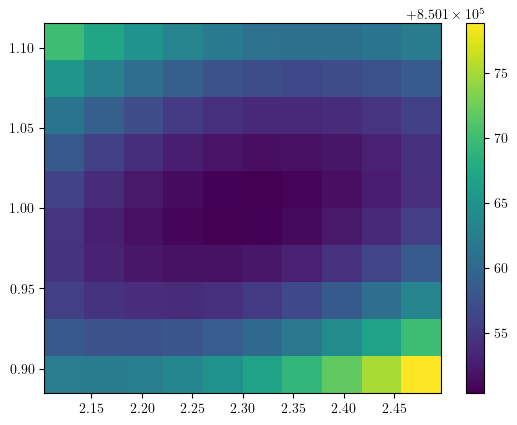

In [31]:
%%time
c_N = fit_N.minuit.contour("par_000_index", "par_001_amplitude", 
                          size = 10, 
                           )

fig = plt.figure()
im = plt.pcolormesh(c_N[0], np.array(c_N[1]), c_N[2],  )
fig.colorbar(im)


In [25]:
%%time
c_N = fit_N.minuit.mncontour("par_000_index", "par_001_amplitude", 
                          size = 5, 
                           )

AttributeError: 'NoneType' object has no attribute 'mncontour'

In [26]:
fig = plt.figure()
im = plt.pcolormesh(c_N[0], np.array(c_N[1]), c_N[2],  )
fig.colorbar(im)

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 640x480 with 0 Axes>

In [ ]:
%%time
fitting_N = 1
if fitting_N:
    
    c_N = fit_N.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                               cl = 0.68, 
                              size = 10, 
                               interpolated = True,
                               )
    
    save(c_N, 'data/5_scan_N_68_index_amplitude.json')
    
    print("95")
    c95_N = fit_N.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                               cl = 0.95, 
                               size = 10, 
                                interpolated = True,
                               )
    save(c95_N, 'data/5_scan_N_95_index_amplitude.json')
else:
    c_N = read('data/5_scan_N_68_index_amplitude.json')
    c95_N = read('data/5_scan_N_95_index_amplitude.json')
    path = f'data/1_model_N.yml'
    dataset_N_load = Dataset_load.load_dataset_N(dataset_N, path) 

# Stat Contours

In [ ]:
color_standard = 'crimson'; color_standard_e = 'palevioletred'
color_nui = 'navy'; color_nui_e = 'cornflowerblue' # 'cornflowerblue'
color_rnd = 'darkgreen'
color_input = 'darkorange'
color_eff = 'darkgreen' ; color_eff_e = 'lightgreen'

In [ ]:
if not fitting and not fitting_N:

    factor = 0.1
    plt.figure()
    plt.plot(c['x'], np.array(c['y'])*factor, '.-', label='Standard 1$\sigma$', color = color_standard)
    plt.plot(c95['x'], np.array(c95['y'])*factor, '.-', label='Standard 2$\sigma$', color = color_standard_e)
    plt.plot(c_N['x'], np.array(c_N['y'])*factor, '.-', label='Effarea 1$\sigma$', color = color_eff)
    plt.plot(c95_N['x'], np.array(c95_N['y']), '.-', label='Effarea 2$\sigma$', color = color_eff_e)
    
    colors_best = [color_eff, color_standard]
    fmts = ['o', 'x']
    for j,d in enumerate([dataset_N_load, datasets]):
        i = d.models.parameters['index'].value
        a = d.models.parameters['amplitude'].value * 1e12
        
        plt.plot(i,a,  fmts[j], color = colors_best[int(j)], )
    
    plt.legend(fontsize=9, loc='best')
    
plt.xlabel("Index")
plt.ylabel("Amplitude [1e-11 TeV-1 s-1 cm-2]")

In [ ]:
if fitting:# and fitting_N:

    plt.figure()
    for ii, seg in enumerate(c.allsegs[0]):
        plt.plot(seg[:,0], seg[:,1], '.-', label=c.levels[ii], color = color_standard)
    for ii, seg in enumerate(c95.allsegs[0]):
        plt.plot(seg[:,0], seg[:,1], '.-', label=c95.levels[ii], color = color_standard_e)    


    plt.legend(fontsize=9, loc='best')

In [ ]:
if fitting_N:

    plt.figure()
    for ii, seg in enumerate(c_N.allsegs[0]):
        plt.plot(seg[:,0], seg[:,1], '.-', label=c_N.levels[ii], color = color_standard)
    #for ii, seg in enumerate(c95.allsegs[0]):
    #    plt.plot(seg[:,0], seg[:,1], '.-', label=c95.levels[ii], color = color_standard_e)    


    plt.legend(fontsize=9, loc='best')